**Note to GitHub viewers:** The internal links within this document may not work on GitHub's interface. For the best experience and to enable all features, please view this notebook in a Jupyter environment.


### 1. Title: Predicting Video Engagement for Educational Content

### Introduction

#### 1.1 About the Prediction Problem
Engagement is crucial in educational videos, directly affecting the learning experience. Engaging content holds the viewer's attention, promoting longer viewing times essential for effective learning. Engagement is often measured by the video’s watch percentage. A non-engaging video typically results in rapid viewer drop-off, reflected by a low watch percentage. 

This project aims to understand the factors that contribute to educational content's engagement. Using supervised machine learning, we predict a video's engagement level based on various features extracted from transcripts, audio tracks, and hosting platforms.

#### 1.2 Dataset Overview
The dataset provided for this project comprises two files: `train.csv` and `test.csv`. Each row in these files represents an individual educational video, with various features describing the content's properties. The target variable, `engagement`, is binary, indicating whether the median watch percentage across all viewers is at least 30% (True) or not (False).

- `train.csv`: This file is used for training the model. It contains the features and the target variable.
- `test.csv`: This file is used for testing the model. It contains only the features.

#### 1.3 Features Description
- `title_word_count`: Number of words in the video title.
- `document_entropy`: Score reflecting the diversity of topics covered in the video, based on the transcript. Lower scores suggest a more focused and cohesive video.
- `freshness`: Number of days since the video's publication date (calculated from 01/01/1970). Recent videos have higher freshness values.
- `easiness`: Text difficulty score derived from the transcript, with lower scores indicating more complex language.
- `fraction_stopword_presence`: Fraction of stopwords present in the video transcript.
- `speaker_speed`: Presenter's average speaking rate in words per minute.
- `silent_period_rate`: Fraction of the video duration without speaking.

#### 1.4 Evaluation Metric
The model's performance is assessed using the Area Under the Receiver Operating Characteristic (ROC) Curve (AUC). A minimum AUC of 0.8 is mandatory, while scores above 0.85 yield full points.

#### 1.5 Objective
This project aims to develop a predictive model that accurately estimates the engagement level of educational videos. Through exploratory data analysis, feature engineering, model training, and hyperparameter tuning, the project seeks to identify the significant features influencing engagement and optimize the model for higher predictive accuracy. The insights and findings from this project will offer valuable guidance for creating engaging educational content in the future.

#### 1.6 Constraints
The project has a significant constraint: the final model’s training runtime should not exceed 10 minutes.
.


### Table of Contents

1. [Title and Introduction](#1.-Title:-Predicting-Video-Engagement-for-Educational-Content)
   - [1.1 About the Prediction Problem](#1.1-About-the-Prediction-Problem)
   - [1.2 Dataset Overview](#1.2-Dataset-Overview)
   - [1.3 Features Description](#1.3-Features-Description)
   - [1.4 Evaluation Metric](#1.4-Evaluation-Metric)
   - [1.5 Objective](#1.5-Objective)
   - [1.6 Constraints](#1.6-Constraints)
2. [Problem Statement](#2.-Problem-Statement)
   - [2.1 Definition of Engagement](#2.1-Definition-of-Engagement)
   - [2.2 Why Predict Engagement?](#2.2-Why-Predict-Engagement?)
   - [2.3 Prediction Task](#2.3-Prediction-Task)
3. [Import Libraries](#3.-Import-Libraries)
4. [Data Loading](#4.-Data-Loading)
5. [Exploratory Data Analysis (EDA)](#5.-Exploratory-Data-Analysis-(EDA))
   - [5.1 Understand the Data Structure](#5.1-Understand-the-Data-Structure)
   - [5.2 Descriptive Statistics](#5.2-Descriptive-Statistics)
   - [5.3 Data Visualization](#5.3-Data-Visualization)
   - [5.4 Correlation Analysis](#5.4-Correlation-Analysis)
   - [5.5 Preliminary Feature Selection](#5.5-Preliminary-Feature-Selection)
   - [5.6 Feature Engineering Ideas](#5.6-Feature-Engineering-Ideas)
   - [5.7-EDA-Recommendations-Summary](#5.7-EDA-Recommendations-Summary)
6. [Model Selection Strategy and Considerations](#6.-Model-Selection-Strategy-and-Considerations)
7. [Baseline AUC Scores](#7.-Baseline-AUC-Scores)
8. [Data Preprocessing](#8.-Data-Preprocessing)
9. [Model Building](#9.-Model-Building)
10. [Hyperparameter Tuning](#10.-Hyperparameter-Tuning)
11. [Results and Discussion](#11.-Results-and-Discussion)
12. [Future Work](#12.-Future-Work)


### 2. Problem Statement
The goal of this project is to predict the engagement levels of educational videos.

#### 2.1 Definition of Engagement
Engagement is measured by the median percentage of each video watched by viewers. A video with a median watch percentage of 30% or higher is considered engaging.

#### 2.2 Why Predict Engagement?
- **Content Improvement:** Identifying engaging content features allows for the creation of more effective educational materials.
- **Personalized Learning:** Engagement predictions enable the recommendation of compelling videos, fostering a personalized learning experience.
- **Resource Efficiency:** For platforms hosting videos, these predictions assist in promoting quality content and efficiently allocating resources.

#### 2.3 Prediction Task
Develop a predictive model using supervised machine learning to estimate a video’s likelihood of engagement, utilizing various extracted features. The model's performance will be evaluated based on the Area Under the ROC Curve (AUC), requiring a minimum AUC of 0.8 and over 0.85 to receive full points.

### 3. Import Libraries


In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import math

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Setting the aesthetic style of the plots
sns.set_style("whitegrid")

# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from scipy.stats import skew, randint, boxcox, uniform, loguniform
from imblearn.over_sampling import SMOTE

# Building and Evaluating models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.base import clone

# Model Evaluation and Hyperparameter Tuning
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Calibration of probabilities
from sklearn.calibration import  CalibratedClassifierCV, calibration_curve

# Ignore future deprecation warnings
import warnings
from sklearn.exceptions import ConvergenceWarning, FitFailedWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=FitFailedWarning)
warnings.filterwarnings('ignore', category=UserWarning)

### 4. Data Loading

This section will cover the initial steps of loading the dataset into the notebook. Before we begin with data loading, ensure that the dataset files, `train.csv` and `test.csv`, are available in the project directory.

In [2]:
# Loading training data
train_df = pd.read_csv('assets/train.csv')

# Loading testing data
test_df = pd.read_csv('assets/test.csv')

### 5. Exploratory Data Analysis (EDA)

<a id='5.1-Understand-the-Data-Structure'></a>
### 5.1 Understand the Data Structurre

In [3]:
# Data Summary
train_df.head()

,id,title_word_count,document_entropy,freshness,easiness,fraction_stopword_presence,normalization_rate,speaker_speed,silent_period_rate,engagement
0,1,9,7.753995,16310,75.583936,0.553664,0.034049,2.997753,0.0,True
1,2,6,8.305269,15410,86.870523,0.584498,0.018763,2.635789,0.0,False
2,3,3,7.965583,15680,81.915968,0.605685,0.030720,2.538095,0.0,False
3,4,9,8.142877,15610,80.148937,0.593664,0.016873,2.259055,0.0,False
4,5,9,8.161250,14920,76.907549,0.581637,0.023412,2.420000,0.0,False


In [4]:
# Data Types
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9239 entries, 0 to 9238
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          9239 non-null   int64  
 1   title_word_count            9239 non-null   int64  
 2   document_entropy            9239 non-null   float64
 3   freshness                   9239 non-null   int64  
 4   easiness                    9239 non-null   float64
 5   fraction_stopword_presence  9239 non-null   float64
 6   normalization_rate          9239 non-null   float64
 7   speaker_speed               9239 non-null   float64
 8   silent_period_rate          9239 non-null   float64
 9   engagement                  9239 non-null   bool   
dtypes: bool(1), float64(6), int64(3)
memory usage: 658.8 KB
None


id                            0
title_word_count              0
document_entropy              0
freshness                     0
easiness                      0
fraction_stopword_presence    0
normalization_rate            0
speaker_speed                 0
silent_period_rate            0
engagement                    0
dtype: int64


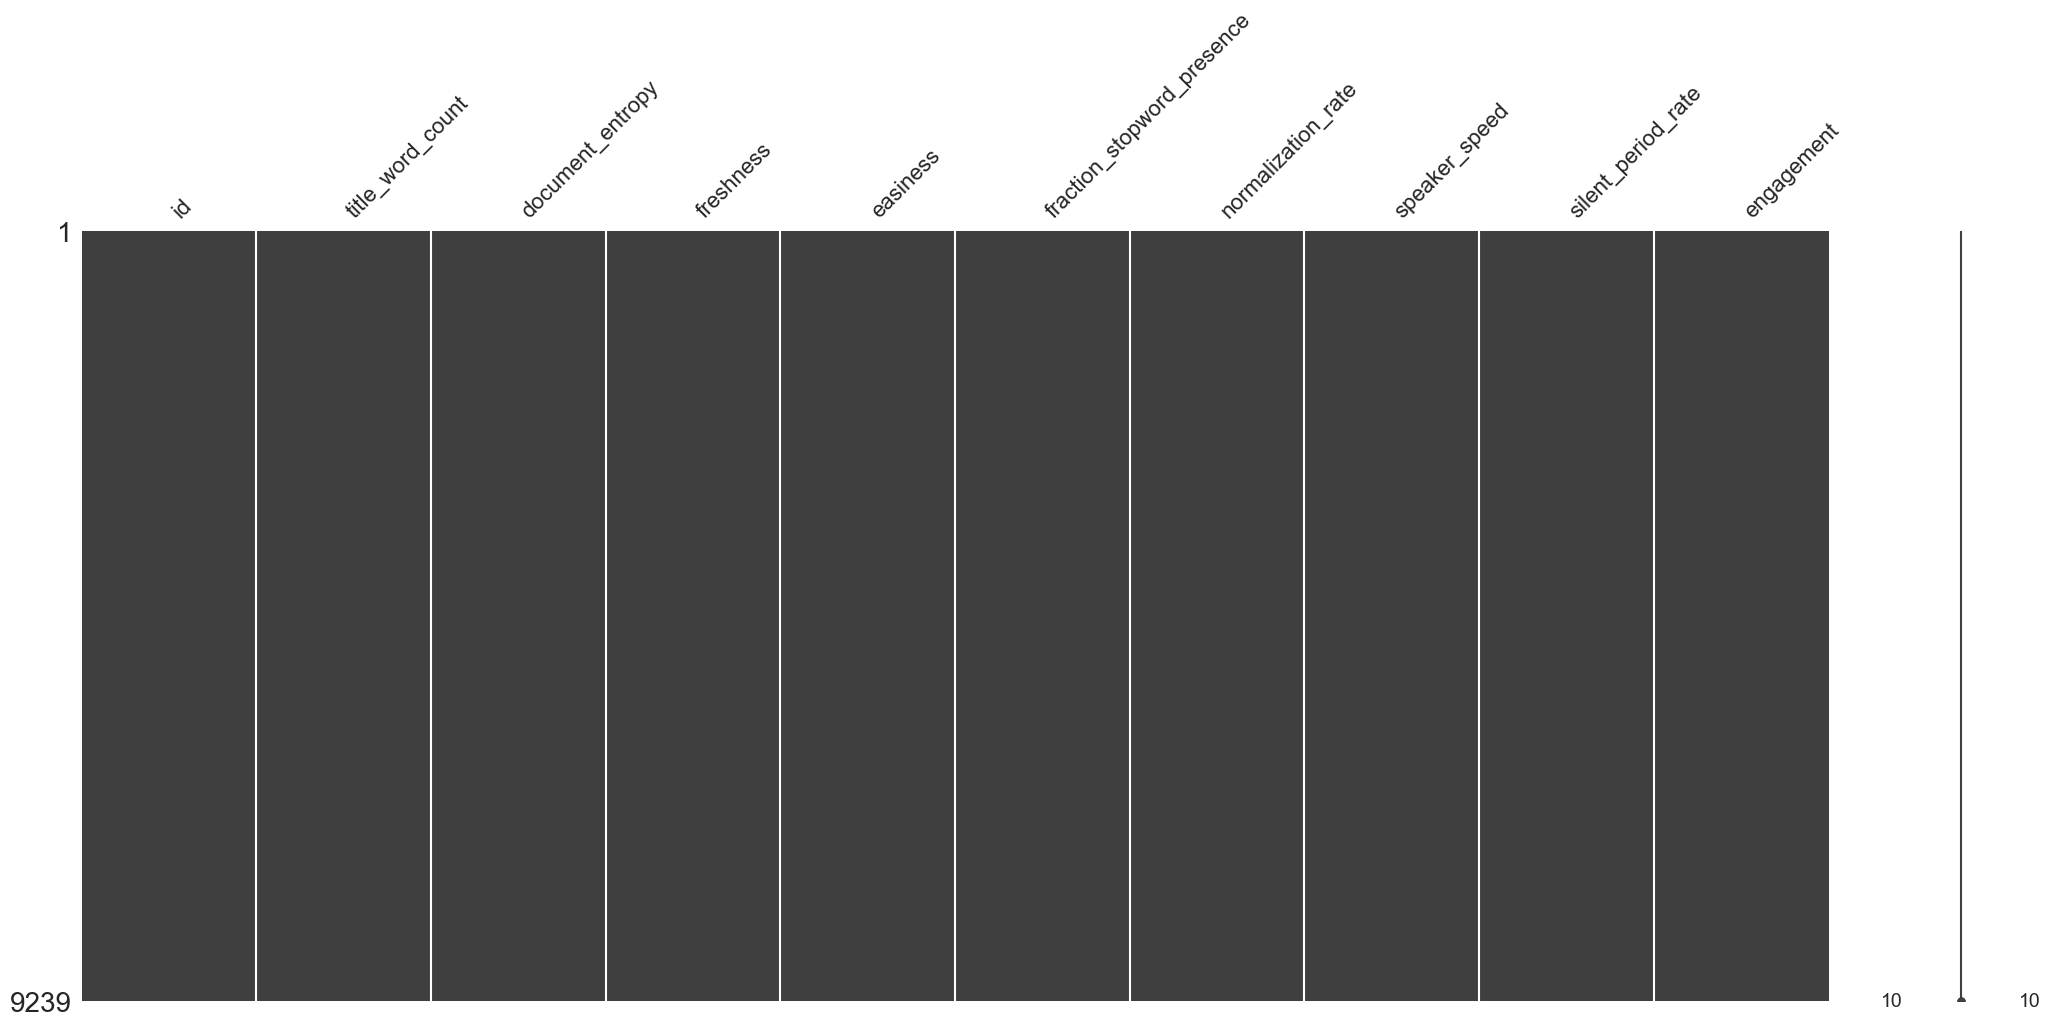

In [5]:
# Check for Missing Values
print(train_df.isnull().sum())


msno.matrix(train_df)
plt.show()

In [6]:
# Check for Duplicate Rows
duplicate_rows = train_df[train_df.duplicated()]

# Check for Constant Columns
constant_columns = [col for col in train_df.columns if train_df[col].nunique() <= 1]

# Print the results
print('Number of Duplicate Rows:', len(duplicate_rows))
print('Constant Columns:', constant_columns)

Number of Duplicate Rows: 0
Constant Columns: []


<a id='5.2-Descriptive-Statistics'></a>
### 5.2 Descriptive Statistics

In [7]:
# Summary statistics
train_df.describe()

,id,title_word_count,document_entropy,freshness,easiness,fraction_stopword_presence,normalization_rate,speaker_speed,silent_period_rate
count,9239.000000,9239.000000,9239.000000,9239.000000,9239.000000,9239.000000,9239.000000,9239.000000,9239.000000
mean,4620.000000,7.701050,7.792685,14808.587509,84.756029,0.612214,0.021354,2.413320,0.146606
std,2667.213902,3.785066,0.697710,1208.953646,8.303489,0.051872,0.009545,1.588296,0.172030
min,1.000000,1.000000,0.000000,10830.000000,28.210966,0.000000,0.000000,0.000302,0.000000
25%,2310.500000,5.000000,7.594235,14070.000000,80.415060,0.589632,0.014974,1.976727,0.000000
50%,4620.000000,7.000000,7.875103,14750.000000,84.482122,0.613127,0.019843,2.267133,0.104915
75%,6929.500000,10.000000,8.164166,15600.000000,88.388711,0.634585,0.026288,2.539207,0.250927
max,9239.000000,33.000000,9.278573,17430.000000,122.032000,1.000000,0.101990,50.850000,1.168239


#### Observations: Summary statistics

* `title_word_count`: Ranges from 1 to 33 with a mean of approximately 7.7. This suggests that the titles are usually short and concise.
* `document_entropy`: The values are mostly concentrated around the mean of 7.79, but it varies from 0 to 9.28, suggesting a good level of variability in the text content.
* `freshness`: Ranges from 10,830 to 17,430 with a mean of approximately 14,809.
* `easiness`: Has a mean of about 84.76 and a standard deviation of 8.3, indicating that the data points are relatively close to the mean.
* `fraction_stopword_presence`: The mean is approximately 0.61, and the values vary between 0 and 1.
* `normalization_rate`: The values vary between 0 and 0.1 with a mean of approximately 0.021.
* `speaker_speed`: Has a mean of approximately 2.41 but a high standard deviation of 1.59, indicating a wide spread.
* `silent_period_rate`: Ranges from 0 to 1.17 with a mean of 0.147.

In [8]:
# Distribution of the target variable
train_df['engagement'].value_counts(normalize=True) * 100

engagement
False    90.291157
True      9.708843
Name: proportion, dtype: float64

#### Observations: Distribution - Target Variable (engagement)
* `Class Distribution`: About **90.3%** of the samples are labeled as False, and only about **9.7%** are labeled as True. This indicates that the dataset is imbalanced, which we'll need to address.

#### Recommendations:
* `Outliers`: We'll check for outliers in speaker_speed
* `Feature Scaling`: Given that the numerical features are on different scales, we will consider feature scaling.
* `Class Imbalance`: The significant imbalance in the target variable suggests that we might need to use resampling techniques

<a id='5.3-Data-Visualization'></a>
### 5.3 Data Visualization

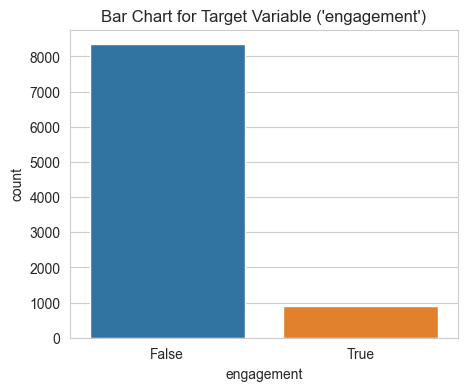

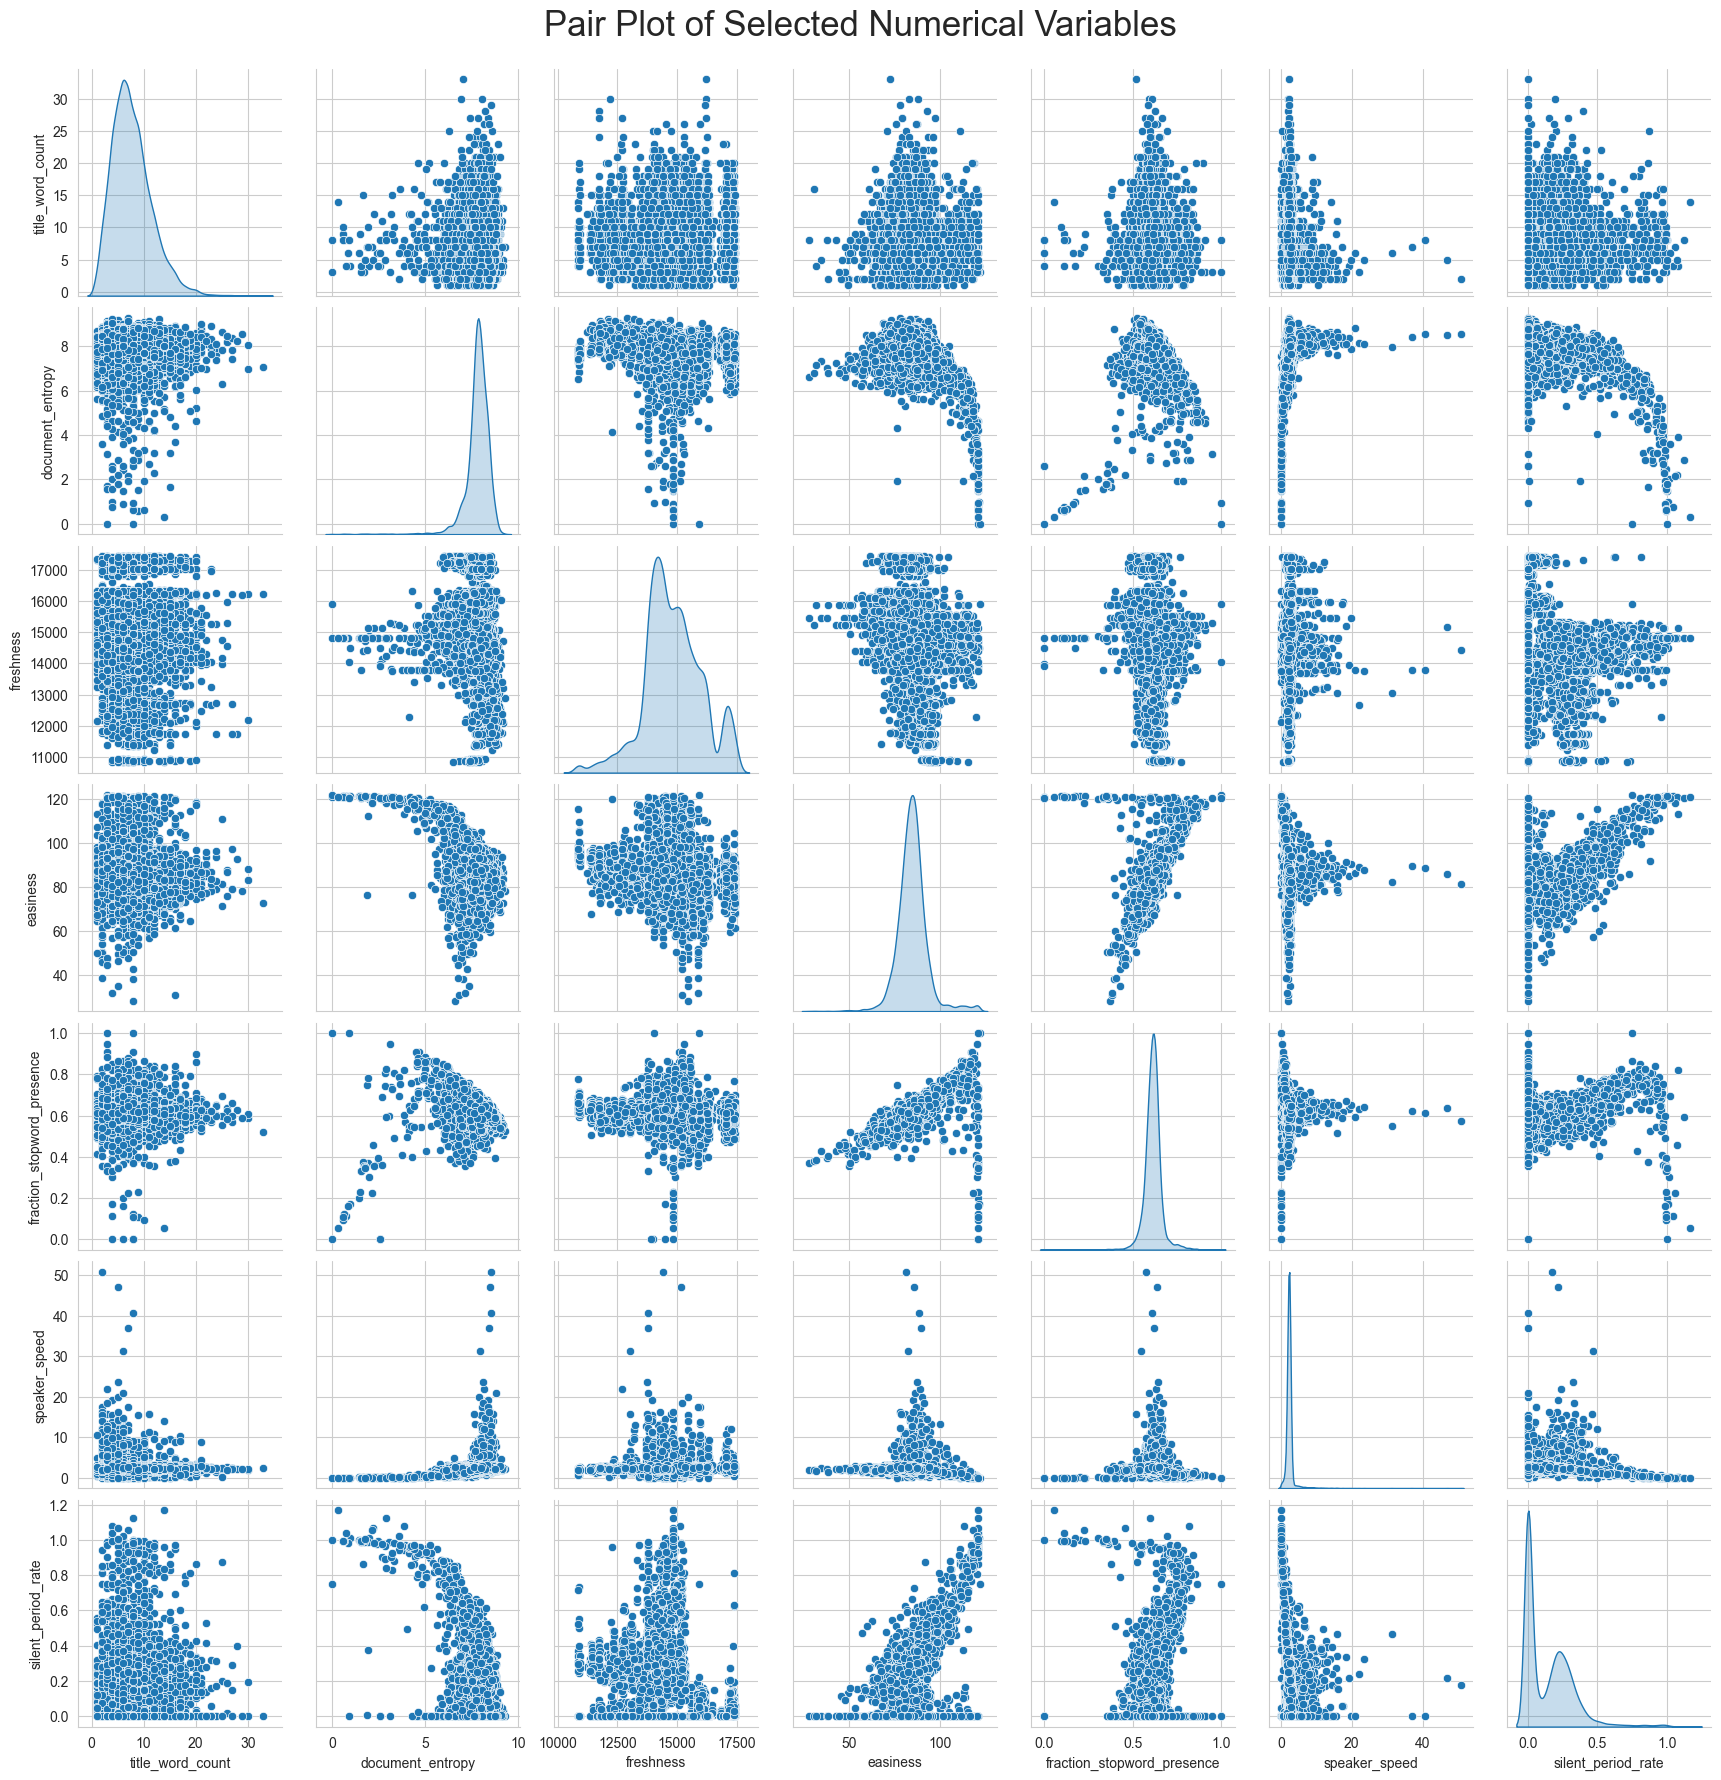

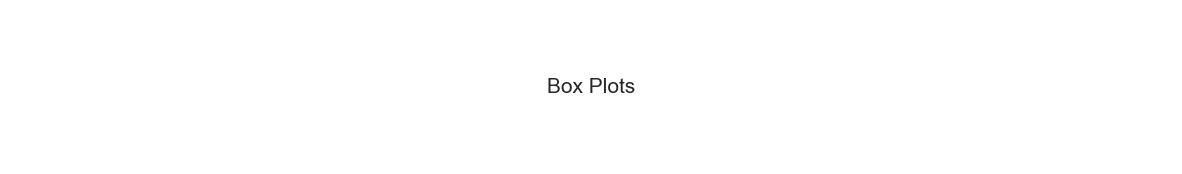

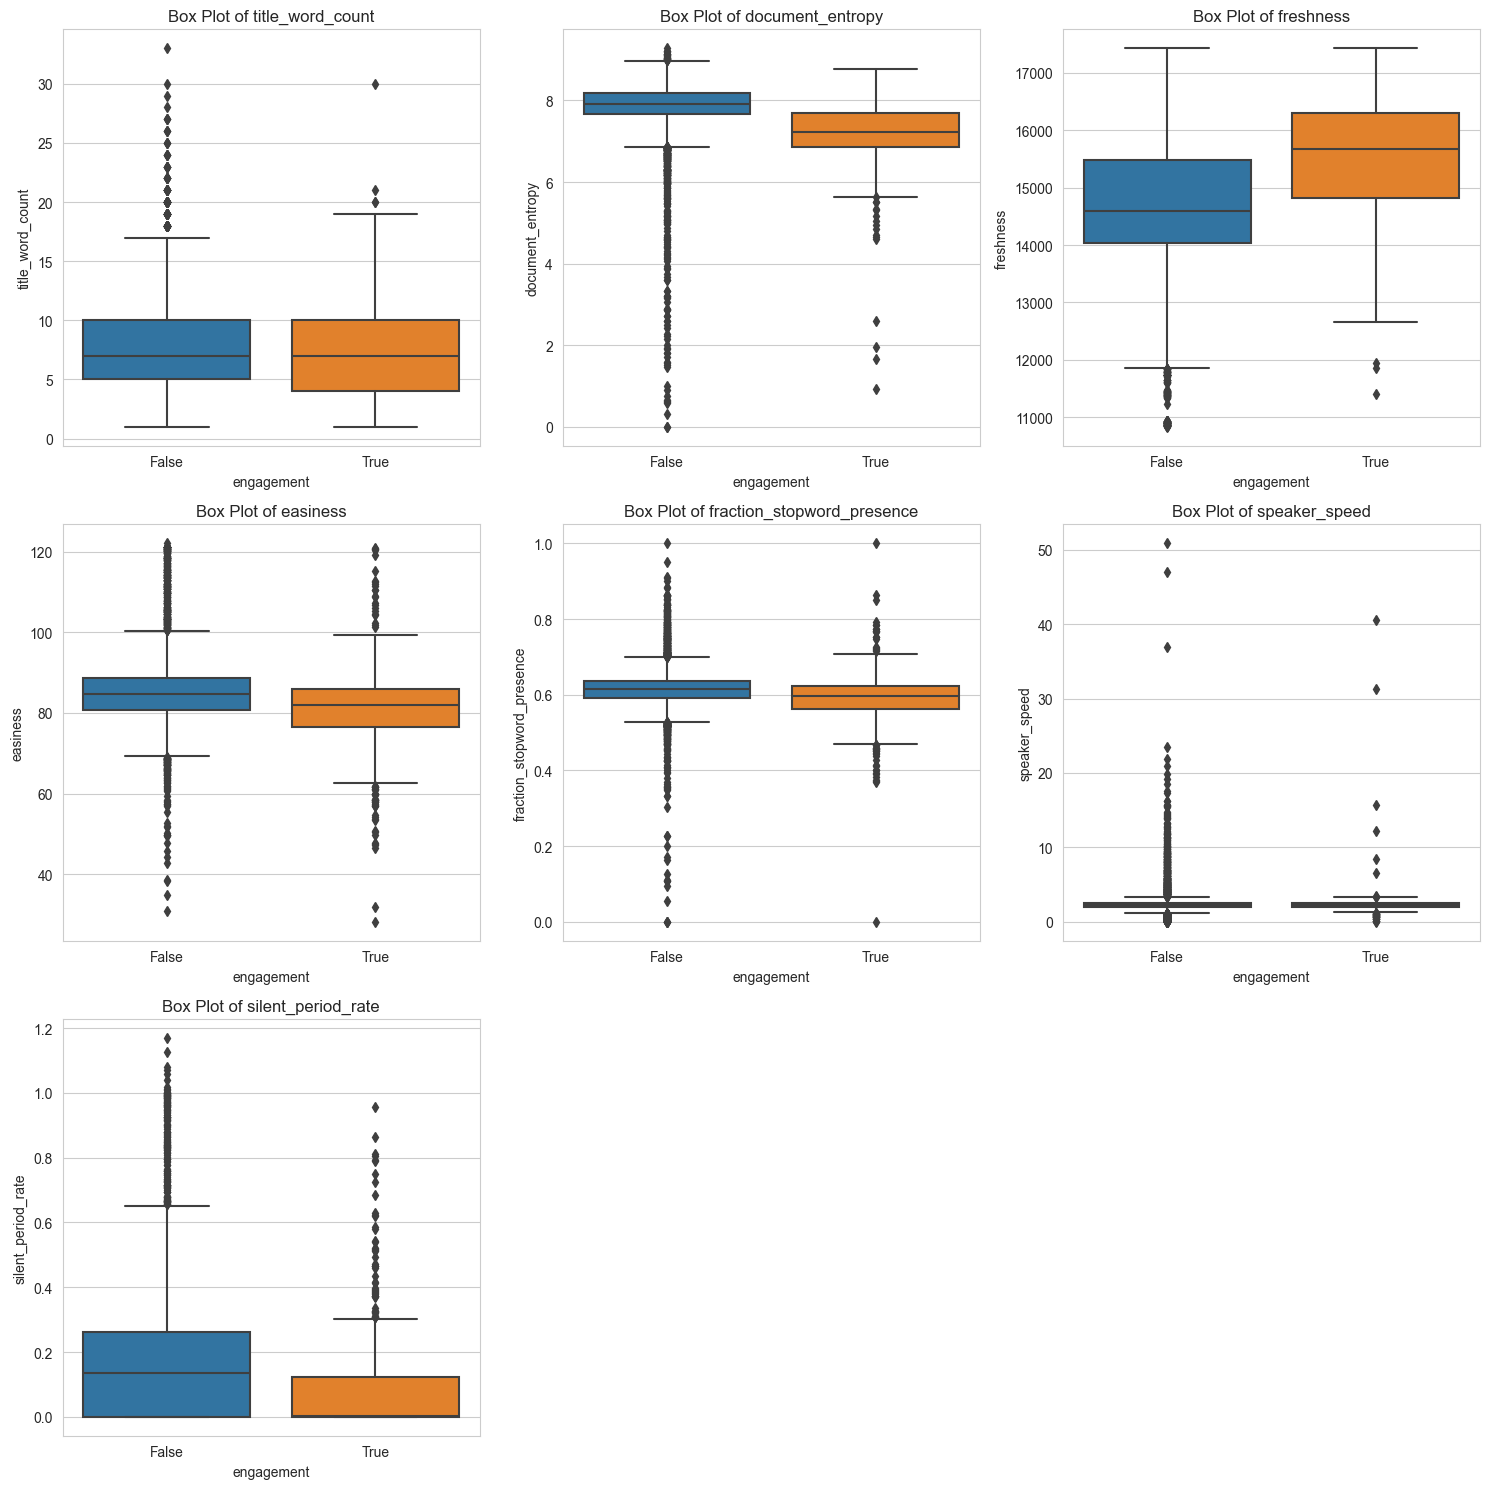

In [9]:
# Removing 'id' and 'normalization_rate' columns
graph_df = train_df.drop(columns=['id', 'normalization_rate'], errors='ignore')

# Setting 'engagement' as target variable
target_variable = 'engagement'

## Bar Chart for Target Variable to visualize class imbalance
plt.figure(figsize=(5, 4))
sns.countplot(x=target_variable, data=graph_df)
plt.title(f"Bar Chart for Target Variable ('{target_variable}')")
plt.show()

# Selecting numerical features excluding 'id', 'features', and 'normalization_rate'
numerical_features = graph_df.select_dtypes(include=[np.number]).columns.tolist()

## Pair Plot for Selected Numerical Variables
sns.pairplot(graph_df[numerical_features], diag_kind='kde')
plt.suptitle("Pair Plot of Selected Numerical Variables", y=1.02, fontsize=25)
plt.show()

# Creating a 'header' figure for Box Plots
plt.figure(figsize=(15, 2))  # Adjust the figure size as needed
plt.text(0.5, 0.5, 'Box Plots', ha='center', va='center', fontsize=15)
plt.axis('off')  # Turn off axis
plt.show()

# Box Plots for feature distribution against the target variable
plt.figure(figsize=(15, math.ceil(len(numerical_features) / 3) * 5))
for index, feature in enumerate(numerical_features, start=1):
    plt.subplot(math.ceil(len(numerical_features) / 3), 3, index)
    sns.boxplot(y=graph_df[feature], x=graph_df[target_variable])
    plt.title(f'Box Plot of {feature}')
plt.tight_layout()
plt.show()


#### Observations: Data Visualization
1. **Class Imbalance in Target Variable (Engagement):**
   - As already observed in the Descriptive Statistics analysis, there is a significant class imbalance in the target variable, with more videos being labeled as not engaging (False) than engaging (True).
2. **Outliers:**
   - Several features exhibit outliers:
     - **Title Word Count**: Some videos have unusually long titles.
     - **Speaker Speed**: There are videos with extremely high or low speaking speeds.
     - **Silent Period Rate**: Some videos have a high silent period rate.
3. **Feature Distributions:**
   - Some features have skewed distributions:
     - **Silent Period Rate**: Many videos have no silent periods, with a distribution skewed towards zero.
     - **Speaker Speed**: The distribution is right-skewed, with a few videos having very high speaking speeds.
     - **Normalization Rate**: The data is positively skewed, indicating that most of the values are clustered at the lower end.

#### Recommendations:
1. **Handle Class Imbalance:**
   - The following techniques will be considered: oversampling the minority class, undersampling the majority class, or using synthetic minority over-sampling techniques (SMOTE).
2. **Handle Outliers:**
   - Investigate outliers further to determine whether they are errors or legitimate data points.
   - Consider removing, transforming, or imputing outliers.
3. **Feature Transformation:**
   - Logarithmic, square root, or Box-Cox transformations will be consider for transforming skewed features to achieve a more normal distribution.
   - Standardize or normalize features to bring them to a similar scale.

<a id='5.4-Correlation-Analysis'></a>
#### 5.4 Correlation Analysis

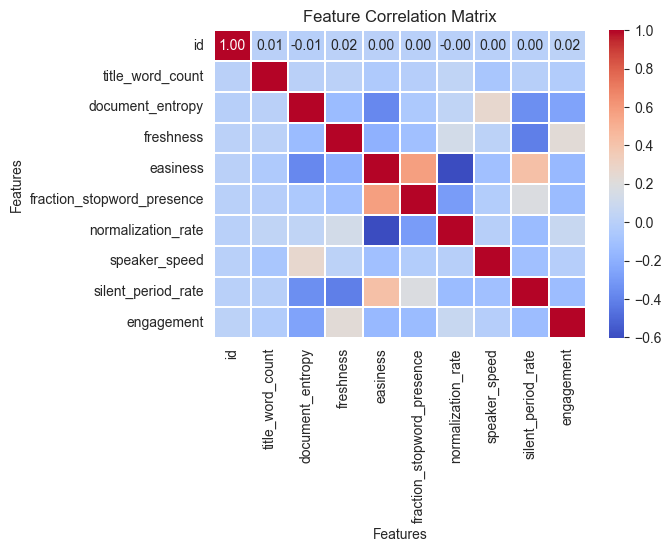

,id,title_word_count,document_entropy,freshness,easiness,fraction_stopword_presence,normalization_rate,speaker_speed,silent_period_rate,engagement
id,1.000000,0.005341,-0.005961,0.015104,0.004669,0.002193,-0.001831,0.001404,0.002241,0.021167
title_word_count,0.005341,1.000000,0.007861,0.010169,-0.040933,-0.014945,0.039705,-0.076406,-0.007335,-0.030120
document_entropy,-0.005961,0.007861,1.000000,-0.140501,-0.376209,-0.057805,0.038679,0.264153,-0.352060,-0.263970
freshness,0.015104,0.010169,-0.140501,1.000000,-0.191736,-0.110930,0.131065,0.016699,-0.414012,0.225711
easiness,0.004669,-0.040933,-0.376209,-0.191736,1.000000,0.577259,-0.604340,-0.112795,0.423378,-0.150089
fraction_stopword_presence,0.002193,-0.014945,-0.057805,-0.110930,0.577259,1.000000,-0.291580,-0.026725,0.180411,-0.136340
normalization_rate,-0.001831,0.039705,0.038679,0.131065,-0.604340,-0.291580,1.000000,-0.002837,-0.134752,0.075936
speaker_speed,0.001404,-0.076406,0.264153,0.016699,-0.112795,-0.026725,-0.002837,1.000000,-0.111824,-0.010440
silent_period_rate,0.002241,-0.007335,-0.352060,-0.414012,0.423378,0.180411,-0.134752,-0.111824,1.000000,-0.130908
engagement,0.021167,-0.030120,-0.263970,0.225711,-0.150089,-0.136340,0.075936,-0.010440,-0.130908,1.000000


In [10]:
# Calculate the correlation matrix
correlation_matrix = train_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(6, 4))

# Generate a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.05)

# Set plot title and axis labels
plt.title('Feature Correlation Matrix')
plt.xlabel('Features')
plt.ylabel('Features')

# Show plot
plt.show()

# Return the correlation matrix for reference
correlation_matrix

#### Observations:
##### Engagement Correlations:
- **Freshness:** Positive correlation (0.23) with engagement, suggesting that newer videos tend to be more engaging.
- **Document Entropy:** Negative correlation (-0.26) with engagement, suggesting that videos focused on fewer topics might be more engaging.
- **Easiness:** Negative correlation (-0.15) with engagement, indicating that videos with more complex language might be more engaging.
- **Silent Period Rate:** Negative correlation (-0.13) with engagement, suggesting that videos with fewer silent periods tend to be more engaging.

##### Feature Correlations:
- **Easiness** has a strong positive correlation with **Fraction of Stopword Presence (0.58)**, indicating that videos with more straightforward language have a higher fraction of stopwords.
- **Easiness** has a moderate negative correlation with **Document Entropy (-0.38)**.
- **Silent Period Rate** has a moderate negative correlation with **Freshness (-0.41)** and **Document Entropy (-0.35)**, and a moderate positive correlation with **Easiness (0.42)**.

##### Recommendations:
- **Multicollinearity:** While moderate correlations exist between some features, there isn't a very high correlation that would typically necessitate removing a feature due to multicollinearity (common threshold is above 0.8 or below -0.8).
- **Feature Selection:** Consider using feature selection techniques. See feature selection recommendation in next section.
- **Feature Engineering:** See feature engineering recommendations below.


<a id='5.5-Preliminary-Feature-Selection'></a>
### 5.5 Preliminary Feature Selection

#### Recommendations:
- Initially, we will use all features for modeling, then iteratively refine based on performance and importance.
- We will also consider models that inherently perform feature selection, like tree-based algorithms.

#### There is limited motivation to perform feature selection for this project due to the following:
   - With already few features, the benefit of feature selection is minimal.
   - Removing features may lead to loss of valuable information.
   - Improper feature selection can lead to overfitting.
   - Feature importance varies between different models.
   - The process can be computationally intensive.

<a id='5.6-Feature-Engineering-Ideas'></a>
### 5.6 Feature Engineering Ideas

#### 1. **Interaction Terms:**
   - We may create interaction terms between features that are likely to influence engagement jointly. For instance, considering the correlations observed, we might explore interactions between `easiness` and `fraction_stopword_presence`, etc.

#### 2. **Polynomial Features:**
   - For features that might have a non-linear relationship with the target, we will consider creating polynomial features. However, we must be cautious as polynomial features can quickly increase the dimensionality of the data.

#### 3. **Binning:**
   - For continuous variables like `speaker_speed`, we might create bins or categories that might help capture the non-linear effect on the target variable.
ariable.


<a id='5.7-EDA-Recommendations-Summary'></a>
### 5.7 EDA Recommendations Summary

#### 1. **Handle Outliers:**
   - Handle outliers in `speaker_speed, title word count, silent period rate`.
   - We will use transformation, to avoid data loss.
#### 2. **Feature Scaling:**
   - Apply MinMax Scaling to normalize the features, ensuring that all numerical features are on a similar scale, facilitating better model convergence and performance.
#### 3. **Class Imbalance:**
   - Utilize SMOTE (Synthetic Minority Over-sampling Technique) to address the significant class imbalance in the target variable, enhancing the model's ability to generalize and perform well on both classes.
#### 4. **Feature Transformation:**
    For features with high positive skewness, we will apply logarithmic or square root transformation. And for those with negative skewness, we will apply square or cube root.
   - **Silent Period Rate**: Many videos have no silent periods, with a distribution skewed towards zero.
   - **Speaker Speed**: The distribution is right-skewed, with a few videos having very high speaking speeds.
   - **Normalization Rate**: The data is positively skewed, indicating that most of the values are clustered at the lower end.
#### 5. **Feature Selection:**
   - Initially we will include all features for modeling, refining iteratively based on performance and importance.
   - We will use models that inherently offer insights into feature importance, like tree-based algorithms, but exercise caution to prevent information loss and overfitting.
#### 6. **Feature Engineering:**
   - Experiment with interaction terms between features (e.g., between `easiness` and `fraction_stopword_presence`).
   - Explore polynomial features for capturing non-linear relationships, with caution regarding data dimensionality.
   - Implement binning for continuous variables like `speaker_speed` to encapsulate non-linear effects on the target variable.
### Note:
- Multicollinearity will not be explicitly addressed in this phase as it does not critically impact the modeling algorithms planned for use(see next section), and the moderate correlations observed do not warrant immediate action.


### 6. Model Selection Strategy and Considerations

1. **Logistic Regression with Regularization:**
   - **Rationale:** 
      - Provides a fast and interpretable baseline.
      - Regularization helps prevent overfitting.
2. **Random Forest Classifier:**
   - **Rationale:**
      - Robust to outliers and imbalances.
      - Offers feature importance for feature selection.
3. **Gradient Boosting Machines (XGBoost or LightGBM):**
   - **Rationale:**
      - Typically yields high performance.
      - Effective for imbalanced datasets with appropriate tuning.
4. **Support Vector Machines (SVM) with RBF Kernel:**
   - **Rationale:**
      - Works well in high-dimensional spaces.
      - Requires careful tuning and pre-processing.
5. **Neural Networks:**
   - **Rationale:**
      - Can model complex non-linear patterns.
      - Requires more data and careful tuning.
### Strategy:
- **Start Simple:** Begin with simpler models for a baseline.
- **Incremental Complexity:** Progress to more complex models for potentially higher accuracy.
- **Continuous Evaluation:** Assess performance at each step using AUC score.

### 7. Baseline AUC Scores

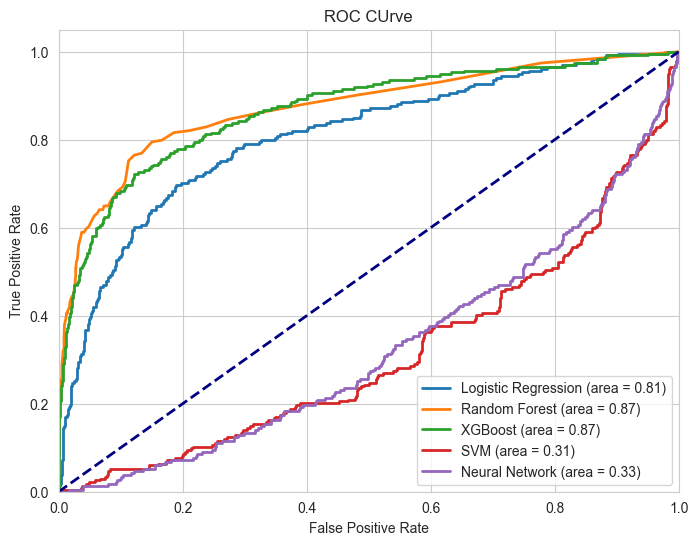

In [11]:
# Get the features data
X_baseline = train_df.iloc[:,1:-1]

# Get the target data
y_baseline = train_df.iloc[:,-1]

# Split the data into training and test sets(validation set)
X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline = train_test_split(X_baseline, y_baseline, random_state=0)

# Logistic Regression Classifier
baseline_logreg = LogisticRegression(random_state=0)

# Random Forest Classifier
baseline_rf = RandomForestClassifier(random_state=0)

# XGBoost Classifier
baseline_xgb = XGBClassifier(random_state=0)

# SVM Classifier
baseline_svm = SVC(random_state=0, probability=True)  # Set probability to True for predict_proba

# Neural Network Classifier
baseline_nn_classifier = MLPClassifier(random_state=0)

# List of classifiers
classifiers = [baseline_logreg, baseline_rf, baseline_xgb, baseline_svm, baseline_nn_classifier]
classifier_names = ['Logistic Regression', 'Random Forest', 'XGBoost', 'SVM', 'Neural Network']

# Dictionary to store the results
results_baseline = {}

# Set up plotting
plt.figure(figsize=(8, 6))

# Iterate over classifiers, train, predict, and plot ROC curve
for clf, name in zip(classifiers, classifier_names):
    # Train the classifier
    clf.fit(X_train_baseline, y_train_baseline)
    
    # Compute predicted probabilities: y_pred_prob
    y_pred_prob_baseline = clf.predict_proba(X_test_baseline)[:,1]
    
    # Compute ROC curve and area under the curve
    fpr_baseline, tpr_baseline, _ = roc_curve(y_test_baseline, y_pred_prob_baseline)
    roc_auc_baseline = auc(fpr_baseline, tpr_baseline)
    
    # Plot ROC curve
    plt.plot(fpr_baseline, tpr_baseline, lw=2, label=f'{name} (area = {roc_auc_baseline:.2f})')

# Customize the plot
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CUrve')
plt.legend(loc="lower right")

# Show the plot
plt.show()

### Baseline Model AUC Scores:

The baseline AUC scores indicate the initial performance of each model without tuning:

- **Random Forest (0.87):** 
  - Top performer at the baseline level, showing strong initial results.
  
- **XGBoost (0.87):** 
  - Close second to Random Forest, also promising and likely to improve with tuning.

- **Logistic Regression (0.81):** 
  - Moderate baseline performance; potential candidate for a fast, simpler model after tuning.

- **SVM (0.31) & Neural Network (0.33):** 
  - Both have significantly lower baseline scores, indicating a need for substantial improvement through preprocessing and parameter tuning.

### Quick Take:
- Prioritize tuning for **Random Forest** and **XGBoost** due to their promising baseline performance.
- **Logistic Regression** could serve as a simpler alternative with further tuning.
- **SVM** and **Neural Network** require more intensive tuning and preprocessing to be competitive. Consider the effort versus payoff when working with these models.


### 8. Data Preprocessing

| Preprocessing Steps                       | Logistic Regression | Random Forest | Gradient Boosting (XGBoost) | SVM (RBF Kernel) | Neural Networks |
|------------------------------------------|---------------------|---------------|-----------------------------|------------------|-----------------|
| **Handle Outliers (Transformation)**     | Yes                 | Optional      | Optional                    | Yes              | Yes             |
| **Feature Scaling (MinMax Scaling)**     | Yes                 | No            | No                          | Yes              | Yes             |
| **Class Imbalance (SMOTE)**              | Yes                 | Yes           | Yes                         | Yes              | Yes             |
| **Feature Transformation**               | Yes                 | Optional      | Optional                    | Yes              | Yes             |
| **Feature Selection**                    | Optional            | Optional      | Optional                    | Optional         | Optional        |
| **Feature Engineering**                  | Optional            | Optional      | Optional                    | Optional         | Optional        |

- **Yes:** The step is recommended for the model to improve performance.
- **No:** The model doesn't necessarily benefit from this step.
- **Optional:** The step might or might not improve performance, and it’s recommended to empirically test its impact.

### Notes:
- **Handle Outliers:** Logistic Regression, SVM, and Neural Networks might be sensitive to outliers, hence transformation is beneficial. Random Forest and XGBoost are generally robus
- **Feature Transformation:** Models sensitive to the distribution of features, like Logistic Regression, SVM, and Neural Networks, might benefit more from feature transformations.
- **Class Imbalance:** All models can benefit from addressing class imbalance since it improves the model's ability to generalize to both classes.t to outliers.
- **Feature Scaling:** Scaling is crucial for Logistic Regression, SVM, and Neural Networks. Random Forest and XGBoost aren't sensitive to the scale of features, but scaling wotransformations.
- **Feature Selection:** Optional for all models but can be beneficial to simplify the model and improve interpretability and performance.
- **Feature Engineering:** Should be empirically tested with each model to evaluate its impct on performance.


### Handling Outliers and Transformation

In [12]:
# Handling Outliers and Transformation for 'speaker_speed', 'silent_period_rate', 'normalization_rate' and 'title_word_count'

# Calculate skewness before transformation
original_skew = skew(train_df[['speaker_speed', 'silent_period_rate', 'normalization_rate','title_word_count']])

# We need to add a constant to make all values strictly positive
train_df['speaker_speed'] = boxcox(train_df['speaker_speed'] + 1)[0]
train_df['silent_period_rate'] = boxcox(train_df['silent_period_rate'] + 1)[0]
train_df['title_word_count'] = boxcox(train_df['title_word_count'] + 1)[0]
train_df['normalization_rate'] = boxcox(train_df['normalization_rate'] + 1)[0]

# Check the skewness again after Box-Cox transformation
transformed_skew_boxcox = skew(train_df[['speaker_speed', 'silent_period_rate', 'normalization_rate', 'title_word_count']])

print(f"Original Skewness:\nSpeaker Speed: {original_skew[0]:.2f}, Silent Period Rate: {original_skew[1]:.2f}, Normalization Rate: {original_skew[2]:.2f}, Title Word Count: {original_skew[3]:.2f}")
print(f"Box-Cox Transformed Skewness:\nSpeaker Speed: {transformed_skew_boxcox[0]:.2f}, Silent Period Rate: {transformed_skew_boxcox[1]:.2f}, Normalization Rate: {transformed_skew_boxcox[2]:.2f}, Title Word Count: {transformed_skew_boxcox[3]:.2f}")

Original Skewness:
Speaker Speed: 12.17, Silent Period Rate: 1.57, Normalization Rate: 1.07, Title Word Count: 0.93
Box-Cox Transformed Skewness:
Speaker Speed: -0.31, Silent Period Rate: 0.23, Normalization Rate: -0.03, Title Word Count: -0.00


### Create X and y sets for model training, evaluation & tuning

In [13]:
# Get the features data
X = train_df.iloc[:,1:-1]

# Get the target data
y = train_df.iloc[:,-1]

# Split the data into training and test sets(validation set)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


### Handling Class Imbalance with SMOTE


In [14]:
# Initialize SMOTE
smote = SMOTE(random_state=0)

# Apply SMOTE to the training data only
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

### 9. Model Building

### Model Initialization and Scaling Pipelines

### Overview:
In this section, we initialize various classification models with their default parameters and set up pipelines for each. These pipelines will first apply feature scaling to the data (using the Min-Max Scaling technique), and then train the initialized model on the scaled data. This approach ensures that our models are being trained on standardized data, which is particularly crucial for models that are sensitive to the scale of the input features.

### Pipelines Setup:
1. **Logistic Regression Pipeline:** Begins with Min-Max Scaling followed by a Logistic Regression classifier.
2. **Support Vector Machine (SVM) Pipeline:** Min-Max Scaling is applied prior to training an SVM with an RBF kernel.
3. **Neural Network Pipeline:** The data is scaled using Min-Max Scaling before training a Multi-layer Perceptron classifier.

### Next Steps:
- These pipelines will be used to train models on the preprocessed data.
- Model performance will be evaluated and compared to select the best-performing model for further tuning and optimization.


In [15]:
logreg_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', LogisticRegression(random_state=0))
])

rf_pipeline = Pipeline([
    ('classifier', RandomForestClassifier(random_state=0))
])

xgb_pipeline = Pipeline([
    ('classifier', XGBClassifier(random_state=0))
])

svm_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', SVC(probability=True, random_state=0))
])

nn_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', MLPClassifier(random_state=0))
])

# Dictionary of pipelines
pipelines = {
    'Logistic Regression': logreg_pipeline,
    'Random Forest': rf_pipeline,
    'XGBoost': xgb_pipeline,
    'SVM': svm_pipeline,
    'Neural Network': nn_pipeline
}

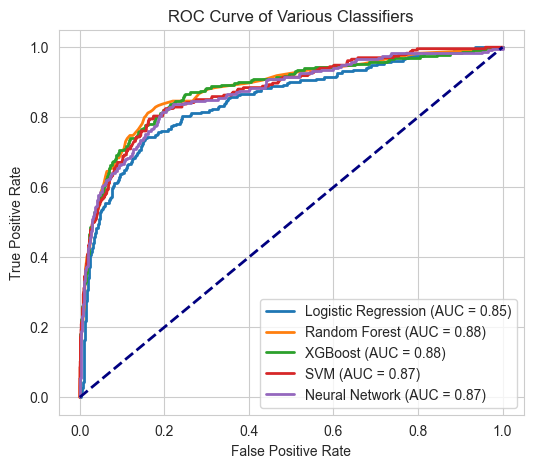

In [16]:
# Set up the plot
plt.figure(figsize=(6, 5))

# Iterate through the pipelines and evaluate each
for name, pipe in pipelines.items():
    # Fitting the pipeline
    pipe.fit(X_train_smote, y_train_smote)
    
    # Making predictions
    predictions = pipe.predict_proba(X_test)[:, 1]
    
    # Getting ROC curve data
    fpr, tpr, _ = roc_curve(y_test, predictions)
    
    # Calculating AUC
    roc_auc = auc(fpr, tpr)
    
    # Plotting ROC Curve
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

# Adding labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Various Classifiers')
plt.legend(loc='lower right')

# Adding a baseline
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Show the plot
plt.show()

### Summary of Model Performance

**Before Preprocessing:**
- **Random Forest (0.87):** Presented a solid starting AUC.
- **XGBoost (0.87):** Matched Random Forest's initial performance.
- **Logistic Regression (0.81):** Offered a respectable baseline AUC.
- **Neural Network (0.33):** Significantly underperformed.
- **SVM (0.31):** Started with the lowest AUC score.

**After Preprocessing:**
- **Random Forest (0.88):** Improved slightly with preprocessing.
- **XGBoost (0.88):** Consistently strong, showing a minor improvement.
- **Logistic Regression (0.85):** Benefited from preprocessing, enhancing its AUC.
- **Neural Network (0.87):** Made a remarkable recovery, aligning with the top performers.
- **SVM (0.87):** Demonstrated significant improvement, equalizing with Neural  the tuning process.


### 10. Hyperparameter Tuning

In [17]:
# Parameter distributions for Random Search
logreg_params = {
    'classifier__penalty': ['l1', 'l2', 'elasticnet'],
    'classifier__C': loguniform(0.001, 100),
    'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

rf_params = {
    'classifier__n_estimators': randint(100, 1000),
    'classifier__max_features': ['auto', 'sqrt', 'log2'],
    'classifier__max_depth': [10, 20, 30, None] + list(randint(5, 10).rvs(3)),
    'classifier__min_samples_split': randint(2, 10),
    'classifier__min_samples_leaf': randint(1, 4),
    'classifier__bootstrap': [True, False]
}

xgb_params = {
    'classifier__n_estimators': randint(100, 1000),
    'classifier__max_depth': randint(3, 10),
    'classifier__learning_rate': loguniform(0.01, 0.2),
    'classifier__min_child_weight': randint(1, 4),
    'classifier__subsample': uniform(0.5, 0.4),
    'classifier__colsample_bytree': uniform(0.5, 0.4)
}

svm_params = {
    'classifier__C': loguniform(0.1, 1000),
    'classifier__gamma': loguniform(0.0001, 1),
    'classifier__kernel': ['rbf', 'poly', 'sigmoid']
}

nn_params = {
    'classifier__hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'classifier__activation': ['tanh', 'relu'],
    'classifier__solver': ['sgd', 'adam'],
    'classifier__alpha': loguniform(0.0001, 0.05),
    'classifier__learning_rate': ['constant','adaptive'],
}

# Dictionary of parameter distributions
param_dists = {
    'Logistic Regression': logreg_params,
    'Random Forest': rf_params,
    'XGBoost': xgb_params,
    'SVM': svm_params,
    'Neural Network': nn_params
}

# Initialize results dictionary
best_pipelines = {}

# Perform RandomizedSearch for each pipeline
for name in pipelines.keys():
    print(f"Performing RandomizedSearchCV for {name}...")
    random_search = RandomizedSearchCV(pipelines[name], param_distributions=param_dists[name], n_iter=100, cv=5, scoring='roc_auc', error_score=np.nan, n_jobs=-1, random_state=42, verbose=1)
    random_search.fit(X_train_smote, y_train_smote)
    best_pipelines[name] = random_search.best_estimator_


Performing RandomizedSearchCV for Logistic Regression...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Performing RandomizedSearchCV for Random Forest...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Performing RandomizedSearchCV for XGBoost...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Performing RandomizedSearchCV for SVM...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Performing RandomizedSearchCV for Neural Network...
Fitting 5 folds for each of 100 candidates, totalling 500 fits


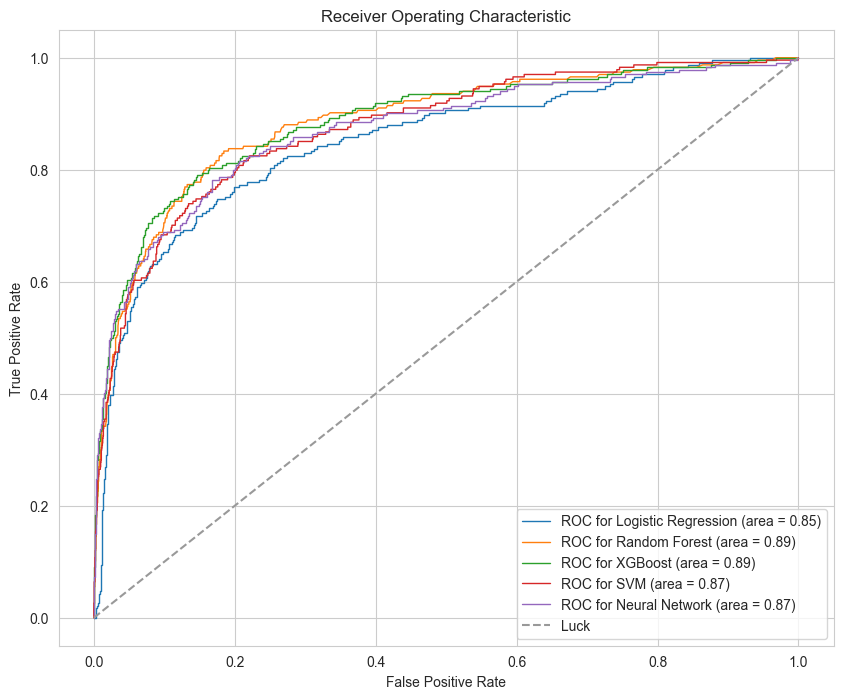

In [18]:
plt.figure(figsize=(10, 8))

for name, model in best_pipelines.items():
    classifier = model.named_steps['classifier']
    
    # Compute the probability of the positive class
    probas_ = model.predict_proba(X_test)
    
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, lw=1, label=f'ROC for {name} (area = {roc_auc:.2f})')

# Reference line for random classifier
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Summary of Model Performance

**Post-Preprocessing and Hyperparameter Tuning:**
- **Random Forest (0.89):** Further improved through tuning, leading the pack.
- **XGBoost (0.89):** Kept pace with Random Forest, jointly holding the top spot.
- **Logistic Regression (0.85):** Maintained a steady performance post-tuning.
- **Neural Network (0.87):** Held its ground with a consistent AUC after tuning.
- **SVM (0.87):** Remained stable and robust after the tuning process.

Given the results, Random Forest and XGBoost are the leading candidates for the final model. The final decision should consider additional factors like training time, interpretability, and how well each model generalizes to unseen data.alizes to unseen data.

### Training Time Performance Test

In [21]:

# Define the classifiers with the best parameters
logreg_classifier = LogisticRegression(C=10.979988817809668, penalty='l1', solver='saga')
rf_classifier = RandomForestClassifier(bootstrap=False, max_depth=30, max_features='sqrt', min_samples_leaf=1, min_samples_split=3, n_estimators=834)
xgb_classifier = XGBClassifier(colsample_bytree=0.8068779412434287, learning_rate=0.11761830810117296, max_depth=9, min_child_weight=1, n_estimators=486, subsample=0.7333475060388639)
svm_classifier = SVC(C=576.1476168524965, gamma=0.7846127244566424, kernel='poly', probability=True)
nn_classifier = MLPClassifier(activation='relu', alpha=0.0002460746712417508, hidden_layer_sizes=(50, 100, 50), learning_rate='adaptive', solver='adam')

# Time the training of each classifier
print("Training Logistic Regression:")
%time logreg_classifier.fit(X_train, y_train)

print("\nTraining Random Forest:")
%time rf_classifier.fit(X_train, y_train)

print("\nTraining XGBoost:")
%time xgb_classifier.fit(X_train, y_train)

# print("\nTraining SVM:")
# %time svm_classifier.fit(X_train, y_train)

print("\nTraining Neural Network:")
%time nn_classifier.fit(X_train, y_train)


Training Logistic Regression:
CPU times: total: 78.1 ms
Wall time: 117 ms

Training Random Forest:
CPU times: total: 28.8 s
Wall time: 35.7 s

Training XGBoost:
CPU times: total: 812 ms
Wall time: 783 ms

Training Neural Network:
CPU times: total: 750 ms
Wall time: 1.99 s

### 11. Results and Discussion

### Final Model Testing and Evaluation Procedure

#### Model Selection: Random Forest
We've selected both the Random Forest and XGBoost best models to be submitted to the university for the final evaluation and scoring.  


```python
rf_classifier = RandomForestClassifier(
    bootstrap=False,
    max_depth=30,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=3,
    n_estimators=834,
    random_state=0  # Optional: for reproducibility
)

xgb_classifier = XGBClassifier(
    colsample_bytree=0.7232408008069364,
    learning_rate=0.033527639013957666,
    max_depth=8,
    min_child_weight=1,
    n_estimators=541,
    subsample=0.8849789179768446,
    random_state=0  # Optional: for reproducibility
)
```

#### Final Testing Procedure
- **Test Dataset**: The university provides a dataset named `test.csv` which will be used for the final testing. Notably, this dataset does not include the target engagement values.
- **Prediction Generation**: We will run our selected model on this dataset, generating a probability for each video entry indicating the likelihood of being engaging.
- **Result Submission**: The generated probabilities will be organized into a Pandas Series object and submitted back to the university for evaluation.
- **Evaluation by University**: The university will evaluate the submitted probabilities against the actual engagement values, computing the final AUC score. This score will be communicated back to us.

#### Why University-Led Evaluation?
- **Objective Assessment**: Having the university conduct the final evaluation ensures an unbiased and objective assessment of the model's performance on unseen data.
- **Integrity and Verification**: This approach maintains the integrity of the testing process and allows for independent verification of the model's generalization capability..


## Final Model Evaluation Score

The university returned an **AUC Score of 0.89** for the Random Forest model.

Unfortunately the training time for the XGBoost model timedout.


### **12. Future Work**
#### **Feature Selection:**
- Iteratively refine feature set based on performance metrics and feature importance.

#### **Feature Engineering:**
- Investigate interaction terms between specific features, for instance, easiness and fraction_stopword_presence, to unveil complex relationships.
- Introduce polynomial features to encapsulate non-linear relationships.
- Implement strategic binning on continuous variables like speaker_speed to effectively capture their non-linear impact on the target variable.ariable.